In [1]:
%matplotlib inline

import os
import h5py
import numpy as np
from matplotlib import pyplot as plt
import fastmri

/usr/local/micapollo01/MIC/DATA/STUDENTS/mvhave7/conda/envs/DL_MRI_reconstruction/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Note: For code documentation, most functions and classes have accompanying docstrings that you can access via the help() function in IPython, e.g.: help(SliceDataset)
# help(fastmri.data.mri_data.SliceDataset)

In [3]:
download_path = '/usr/local/micapollo01/MIC/DATA/SHARED/NYU_FastMRI'
dicom_path = os.path.join(download_path,'fastMRI_brain_DICOM')
train_path = os.path.join(download_path,'multicoil_train')
validation_path = os.path.join(download_path,'multicoil_val')
test_path = os.path.join(download_path,'multicoil_test')
fully_sampled_test_path = os.path.join(download_path,'multicoil_test_full')


In [4]:
file_name = 'file_brain_AXFLAIR_200_6002425.h5'
hf = h5py.File(os.path.join(train_path, file_name))


/usr/local/micapollo01/MIC/DATA/STUDENTS/mvhave7/conda/envs/DL_MRI_reconstruction/lib/python3.6/site-packages/ipykernel_launcher.py:2: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  


k-space has the following shape:
(number of slices, number of coils, height, width)

In [5]:
volume_kspace = hf['kspace'][()]
print(volume_kspace.dtype)
print(volume_kspace.shape)


complex64
(16, 20, 640, 320)


In [6]:
slice_kspace = volume_kspace[10,:,:,:] # Choosing the 10-th slice of this volume


In [7]:
def show_coils(data, slice_nums, cmap=None):
    fig = plt.figure()
    for i, num in enumerate(slice_nums):
        plt.subplot(1, len(slice_nums), i + 1)
        plt.imshow(data[num], cmap=cmap)


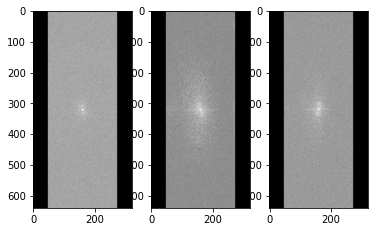

In [8]:
show_coils(np.log(np.abs(slice_kspace) + 1e-9), [0, 5, 10], cmap='gray')


In [9]:
from fastmri.data import transforms as T

slice_kspace_T = T.to_tensor(slice_kspace)               # Convert from numpy array to pytorch tensor
slice_image_T = fastmri.ifft2c(slice_kspace_T)           # Apply Inverse Fourier Transform to get the complex image
slice_image_abs = fastmri.complex_abs(slice_image_T)
slice_image_rss = fastmri.rss(slice_image_abs, dim=0)
ground_truth = slice_image_rss.clone()


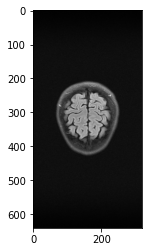

In [10]:
plt.imshow(np.abs(slice_image_rss.numpy()), cmap='gray')


Test functions from the GrappaNet notebook

In [11]:
# Compare mask functions (see fastMRI_tutorial for comparison)

def calculate_mask(nFE,nPE,center_fraction,acc):
    '''
    nFE: number of frequency encoding lines
    nPE: number of phase encoding lines
    center_fraction: fraction of central lines of full sampling
    acc: acceleration factor
    '''
    num_low_freqs = int(round(nPE * center_fraction))
    num_high_freqs = np.ceil(nPE/acc) - num_low_freqs 
    num_outer_lines = nPE - num_low_freqs
    line0 = np.repeat([True],num_high_freqs)
    line0 = np.append(line0,np.repeat([False],num_outer_lines-num_high_freqs))
    np.random.shuffle(line0)
    num_left = num_outer_lines//2
    line = np.append(line0[0:num_left],np.repeat([True],num_low_freqs))
    line = np.append(line,line0[num_left:num_outer_lines])

    mask = np.repeat(line[np.newaxis, ...], nFE, axis=0)
    
    return mask


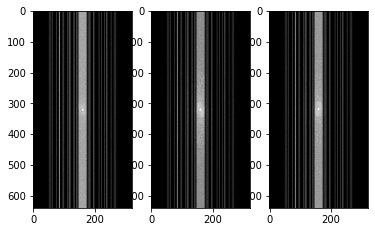

In [12]:
nSL, nCh, nFE, nPE = volume_kspace.shape
mask_2 = calculate_mask(nFE,nPE,0.08,4)
subsampled_k = volume_kspace*mask_2
show_coils(np.log(np.abs(subsampled_k[10,:,:,:]) + 1e-9), [0, 5, 10], cmap='gray')


In [13]:
slice_kspace_T = T.to_tensor(subsampled_k[10,:,:,:])     # Convert from numpy array to pytorch tensor
slice_image_T = fastmri.ifft2c(slice_kspace_T)           # Apply Inverse Fourier Transform to get the complex image
slice_image_abs = fastmri.complex_abs(slice_image_T)     # Compute absolute value to get a real image
slice_image_rss = fastmri.rss(slice_image_abs, dim=0)
no_reconstruction = slice_image_rss.clone()


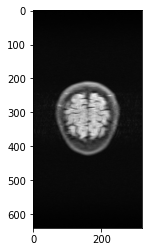

In [14]:
plt.imshow(np.abs(slice_image_rss.numpy()), cmap='gray')


In [15]:
# Test GRAPPA kernel estimation

from pygrappa import find_acs
from collections import defaultdict
from skimage.util import view_as_windows
from pygrappa.train_kernels import train_kernels


def estimate_mdgrappa_kernel(
        kspace,
        calib=None,
        kernel_size=None,
        coil_axis=-1,
        lamda=0.01,
        weights=None,
        ret_weights=False):
   
    # coils to the back
    kspace = np.moveaxis(kspace, coil_axis, -1)
    nc = kspace.shape[-1]

    # Make sure we have a kernel_size
    if kernel_size is None:
        kernel_size = (5,)*(kspace.ndim-1)
    assert len(kernel_size) == kspace.ndim-1, (
        'kernel_size must have %d entries' % (kspace.ndim-1))

    # User can supply calibration region separately or we can find it
    if calib is not None:
        calib = np.moveaxis(calib, coil_axis, -1)
    else:
        # Find the calibration region and split it out from kspace
        calib = find_acs(kspace, coil_axis=-1)

    # Pad the arrays
    pads = [int(k/2) for k in kernel_size]
    adjs = [np.mod(k, 2) for k in kernel_size]
    kspace = np.pad(
        kspace, [(pd, pd) for pd in pads] + [(0, 0)], mode='constant')
    calib = np.pad(
        calib, [(pd, pd) for pd in pads] + [(0, 0)], mode='constant')
    mask = np.abs(kspace[..., 0]) > 0

    padmask = ~mask
    for ii in range(mask.ndim):
        padmask[tuple([slice(0, pd) if ii == jj else slice(None) for jj, pd in enumerate(pads)])] = False
        padmask[tuple([slice(-pd, None) if ii == jj else slice(None) for jj, pd in enumerate(pads)])] = False
    P = defaultdict(list)
    idxs = np.moveaxis(np.indices(mask.shape), 0, -1)[padmask]
    for ii, idx in enumerate(idxs):
        p0 = mask[tuple([slice(ii-pd, ii+pd+adj) for ii, pd, adj in zip(idx, pads, adjs)])].flatten()
        P[p0.tobytes()].append(tuple(idx))
    P = {k: np.array(v).T for k, v in P.items()}

    # We need all overlapping patches from calibration data
    A = view_as_windows(
        calib,
        tuple(kernel_size) + (nc,)).reshape(
            (-1, np.prod(kernel_size), nc,))

    # Set everything up to train and apply weights
    ksize = np.prod(kernel_size)*nc
    S = np.empty((np.max([P[k].shape[1] for k in P] if P else [0]), ksize), dtype=kspace.dtype)

    if not weights:
        # train weights
        Ws = train_kernels(kspace.astype(np.complex128), nc, A.astype(np.complex128), P,
                           np.array(kernel_size, dtype=np.uintp),
                           np.array(pads, dtype=np.uintp), lamda)
        wt={k: Ws[ii, :np.sum(np.frombuffer(k, dtype=bool))*nc, :]
                 for ii, k in enumerate(P)}
        return wt, P


In [16]:
wt,ps = estimate_mdgrappa_kernel(kspace=subsampled_k[10,:,:,:],calib=None,kernel_size=(5,5),coil_axis=0)


/usr/local/micapollo01/MIC/DATA/STUDENTS/mvhave7/conda/envs/DL_MRI_reconstruction/lib/python3.6/site-packages/ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in double_scalars


In [17]:
def apply_kernel_weight(
        kspace,
        calib=None,
        kernel_size=None,
        coil_axis=-1,
        lamda=0.01,
        weights=None,
        P=None):
  
    # coils to the back
    kspace = np.moveaxis(kspace, coil_axis, -1)
    nc = kspace.shape[-1]

    # Make sure we have a kernel_size
    if kernel_size is None:
        kernel_size = (5,)*(kspace.ndim-1)
    assert len(kernel_size) == kspace.ndim-1, (
        'kernel_size must have %d entries' % (kspace.ndim-1))

    # Pad the arrays
    pads = [int(k/2) for k in kernel_size]
    adjs = [np.mod(k, 2) for k in kernel_size]
    kspace = np.pad(
        kspace, [(pd, pd) for pd in pads] + [(0, 0)], mode='constant')
   
    # Set everything up to train and apply weights
    ksize = np.prod(kernel_size)*nc
    S = np.empty((np.max([P[k].shape[1] for k in P] if P else [0]), ksize), dtype=kspace.dtype)
    recon = np.zeros((np.prod(kspace.shape[:-1]), nc), dtype=kspace.dtype)
    mask = np.abs(kspace[..., 0]) > 0
    def _apply_weights(holes, p0, np0, Ws0):
        # Collect all the sources
        for jj, _idx in enumerate(holes.T):
            S[jj, :np0] = kspace[tuple([slice(kk-pd, kk+pd+adj)
                                        for kk, pd, adj in zip(_idx, pads, adjs)])].reshape((-1, nc))[p0, :].flatten()
        # Apply kernel to all sources to generate all targets at once
        recon[np.ravel_multi_index(holes, mask.shape)] = np.einsum(
            'fi,ij->fj', S[:holes.shape[1], :np0], Ws0)

    for ii, (key, holes) in enumerate(P.items()):
        p0 = np.frombuffer(key, dtype=bool)
        np0 = weights[key].shape[0]
        _apply_weights(holes, p0, np0, weights[key])

    # Add back in the measured voxels, put axis back where it goes
    recon = np.reshape(recon, kspace.shape)
    recon[mask] += kspace[mask]
    recon = np.moveaxis(
        recon[tuple([slice(pd, -pd) for pd in pads] + [slice(None)])],
        -1, coil_axis)
    return recon


In [18]:
res = apply_kernel_weight(kspace=subsampled_k[10,:,:,:],calib=None,kernel_size=(5,5),coil_axis=0,weights=wt,P=ps)


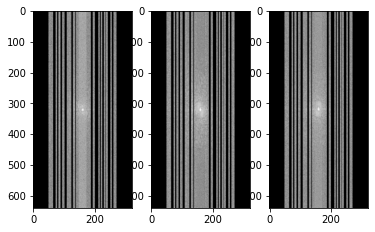

In [19]:
show_coils(np.log(np.abs(res) + 1e-9), [0, 5, 10], cmap='gray')


In [20]:
res_T = T.to_tensor(res)
sampled_image_T = fastmri.ifft2c(res_T)                            # Apply Inverse Fourier Transform to get the complex image
sampled_image_abs = fastmri.complex_abs(sampled_image_T)         # Compute absolute value to get a real image
sampled_image_rss = fastmri.rss(sampled_image_abs, dim=0)
reconstruction_1 = sampled_image_rss.clone()


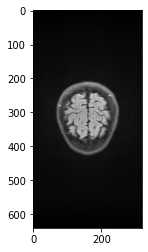

In [21]:
plt.imshow(np.abs(sampled_image_rss.numpy()), cmap='gray')


In [22]:
# Compare with off-the-shelf python packages for grappa

In [23]:
from pygrappa import grappa
import math

def count_nonzero_columns(matrix):
    # Find the center of the matrix
    center = (matrix.shape[1]-1) / 2
    center_right = math.ceil(center)
    center_left = math.floor(center)

    # Initialize counter
    count = 0

    # Iterate over the right columns
    for i in range(center_right, matrix.shape[1]):
        # If all elements in the column are zero
        if np.all(matrix[:, i] == 0):
            break
        else:
            # Increment counter
            count += 1

    return center_left, center_right, count

center_left, center_right, count = count_nonzero_columns(subsampled_k[10,0,:,:])


In [24]:
ncoils, sy, sx = slice_kspace.shape
calib = slice_kspace[:, :, (center_left)-(count):(center_right)+(count)].copy()

res = grappa(subsampled_k[10,:,:,:], calib, kernel_size=(5,5), coil_axis=0)

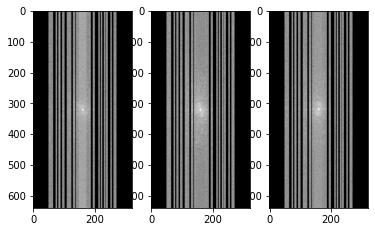

In [25]:
show_coils(np.log(np.abs(res) + 1e-9), [0, 5, 10], cmap='gray')


In [26]:
res_T = T.to_tensor(res)
sampled_image_T = fastmri.ifft2c(res_T)                            # Apply Inverse Fourier Transform to get the complex image
sampled_image_abs = fastmri.complex_abs(sampled_image_T)         # Compute absolute value to get a real image
sampled_image_rss = fastmri.rss(sampled_image_abs, dim=0)
reconstruction_2 = sampled_image_rss.clone()


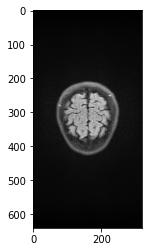

In [27]:
plt.imshow(np.abs(sampled_image_rss.numpy()), cmap='gray')


In [28]:
# Both reconstructions seem visually surprisingly good for R=4 and fraction=0.08, although I suspect that uniform undersampling would result in even better results
# Both reconstructions seem very comparable

# If we do want to further explore other off-the-shelf options, then what about igrappa?
# See: https://pygrappa.readthedocs.io/en/latest/usage.html

In [41]:
# Calculate their MSE's

def mse(actual, pred): 
   actual, pred = np.array(actual), np.array(pred)
   return np.square(np.subtract(actual,pred)).mean()

def nmse(actual, pred):
   mse_result = mse(actual, pred)
   return mse_result/(np.square(actual).mean())


nmse_reconstructed1 = mse(ground_truth, reconstruction_1)
nmse_reconstructed2 = mse(ground_truth, reconstruction_2)
nmse_no_reconstruction = mse(ground_truth, no_reconstruction)
print("In-house reconstruction function error: "+str(nmse_reconstructed1))
print("Off-the-shelf reconstruction function error: "+str(nmse_reconstructed2))
print("Error when just applying an IFT+RSS function: "+str(nmse_no_reconstruction))
print("Reconstruction 1 performs: "+str((nmse_no_reconstruction/nmse_reconstructed1)*100-100)+" percent better than zero filling")
print("Reconstruction 2 performs: "+str((nmse_no_reconstruction/nmse_reconstructed2)*100-100)+" percent better than zero filling")


In-house reconstruction function error: 6.791552e-11
Off-the-shelf reconstruction function error: 6.7819146e-11
Error when just applying an IFT+RSS function: 1.08651727e-10
Reconstruction 1 performs: 59.98070240020752 percent better than zero filling
Reconstruction 2 performs: 60.208046436309814 percent better than zero filling


In [30]:
# Test cropping functions


# K-space cropping

def comp_sub_kspace(subk,crop_size):
    s = subk.shape
    start_height = s[1]//2 - (crop_size[1]//2)
    start_width = s[2]//2 - (crop_size[2]//2)
    return subk[:,start_height:(start_height+crop_size[1]),start_width:(start_width+crop_size[2])]


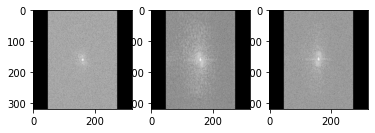

In [31]:
crop_size = (20,320,320)

cropped_slice = comp_sub_kspace(slice_kspace,crop_size)
show_coils(np.log(np.abs(cropped_slice) + 1e-9), [0, 5, 10], cmap='gray')


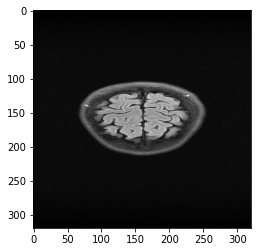

In [32]:
slice_kspace_T = T.to_tensor(cropped_slice)
slice_image_T = fastmri.ifft2c(slice_kspace_T)
slice_image_abs = fastmri.complex_abs(slice_image_T)
slice_image_rss = fastmri.rss(slice_image_abs, dim=0)
plt.imshow(np.abs(slice_image_rss.numpy()), cmap='gray')


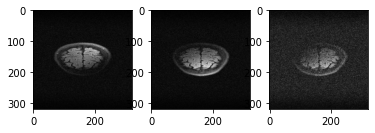

In [33]:
from numpy import fft

cropped_reconstruction = abs(fft.fftshift(fft.ifft2(cropped_slice)))
show_coils(cropped_reconstruction, [0, 5, 10], cmap='gray')

In [1]:
# Some weird stretching is going on...
# This is because we don't crop k-space correctly.
# If we do the cropping like this, we essentially remove the high frequency information, but we don't crop the image data.
# For this, we would need to 'crop' our kspace by leaving out a k-space line in the y direction for every other k-space line. This doubles the sampling distance and thus makes the FOV smaller by a factor 2.

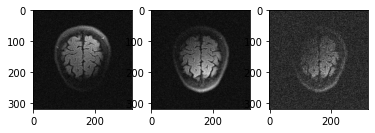

In [35]:
# Image cropping

def comp_img(img,crop_size):
    s = img.shape
    start_height = s[1]//2 - (crop_size[1]//2)
    start_width = s[2]//2 - (crop_size[2]//2)
    return img[:,start_height:(start_height+crop_size[1]),start_width:(start_width+crop_size[2])]


target = abs(fft.fftshift(fft.ifft2(slice_kspace)))
cropped_target = comp_img(target,crop_size)
show_coils(cropped_target, [0, 5, 10], cmap='gray')

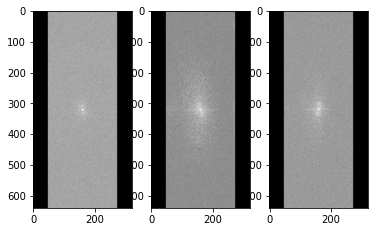

In [36]:
# Repeat everything for different crop size for now to avoid stretching behaviour

crop_size = (20,640,320)

cropped_slice = comp_sub_kspace(slice_kspace,crop_size)
show_coils(np.log(np.abs(cropped_slice) + 1e-9), [0, 5, 10], cmap='gray')

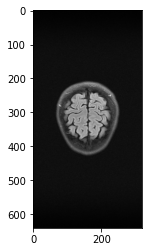

In [37]:
slice_kspace_T = T.to_tensor(cropped_slice)
slice_image_T = fastmri.ifft2c(slice_kspace_T)
slice_image_abs = fastmri.complex_abs(slice_image_T)
slice_image_rss = fastmri.rss(slice_image_abs, dim=0)
plt.imshow(np.abs(slice_image_rss.numpy()), cmap='gray')


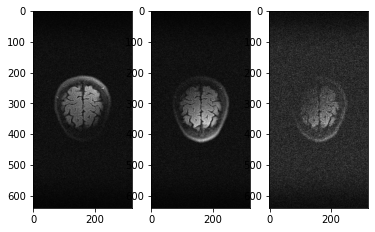

In [38]:
target = abs(fft.fftshift(fft.ifft2(slice_kspace)))
cropped_target = comp_img(target,crop_size)
show_coils(cropped_target, [0, 5, 10], cmap='gray')